In [1]:
from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:


import pandas as pd
import numpy as np
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn_pandas import DataFrameMapper
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, recall_score, precision_score, confusion_matrix,f1_score
from sklearn.linear_model import LogisticRegression, LinearRegression
import statsmodels.api as sm
from sklearn.tree import DecisionTreeClassifier, export_graphviz, DecisionTreeRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
#import graphviz
#from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score,confusion_matrix,mean_absolute_error,mean_squared_error,classification_report
%matplotlib inline
#from vecstack import stacking
from xgboost import XGBClassifier, XGBRegressor
import warnings
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import KMeans
from statsmodels.stats.outliers_influence import variance_inflation_factor
import copy
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
df=pd.read_csv("/content/gdrive/MyDrive/final hackathon datasets/train_data-1638436039700.csv", parse_dates={'salesdate':['year','month','day']}, keep_date_col=False)
df1=pd.read_csv("/content/gdrive/MyDrive/final hackathon datasets/foot_fall-1638434879770.csv")
df2=pd.read_csv("/content/gdrive/MyDrive/final hackathon datasets/discount_features-1638436205304.csv")
df4=pd.read_csv("/content/gdrive/MyDrive/final hackathon datasets/test_data-1638434844061.csv",parse_dates={'salesdate':['year','month','day']}, keep_date_col=False)

In [ ]:
print(df.shape)
print(df1.shape)
print(df2.shape)
print(df4.shape)

In [ ]:
# Start date for the sales is 2015-01-02 and end date is 2018-06-30 for train data
df.head()

In [ ]:
df.tail()

In [ ]:
#Start date for the sales is 2018-07-01 and end date is 2018-07-31 for test data
df4.head()

In [ ]:
df4.tail()

In [ ]:
# As we can observe that discount data is available for test data and for train data(2016-04-01 onwards) we can merge both dataframe and get some insight for dicount in train
df2.head()

In [ ]:
df2.tail()

In [ ]:
# Different levels in our columns
df.nunique()

In [ ]:
df.dtypes

In [ ]:
# There are some negative values of sales for certain medicines,which shows some medicines are returned by the customers
negatives = df[df['sales']<0]
print(negatives.shape)

In [ ]:
negatives.head()

In [ ]:
negatives.tail()

In [ ]:
#Mumbai has the most negative counts and most of the cities have similar value 
print(negatives.city.value_counts())

In [ ]:
negatives.groupby(['medicine']).sales.sum()

In [ ]:
#Top 5 medicines for negative amounts
negatives.nsmallest(5, 'sales')

In [ ]:
#Largest transaction on file is for medicine 518
df[df.sales == df.sales.max()]

In [ ]:
# Medicine 518 is highly demanded by the pharmacies,its 20748 medicines were bought.
df[df['medicine']==518].sort_values('sales',ascending=True).head()

In [ ]:
df[df['medicine']==2472].sort_values('sales',ascending=True).head()

In [ ]:
#Duplicate rows can majorly be seen on a particular date that is 28-02-2018
Duplicate_rows = df[df.duplicated(subset=['salesdate', 'city', 'medicine','sales'], keep='first')]
Duplicate_rows.head()

In [ ]:
print(Duplicate_rows.shape)

In [ ]:
Duplicate_rows.city.value_counts()

In [ ]:
#Maximum amount in duplicate records is 264
Duplicate_rows[Duplicate_rows.sales == Duplicate_rows.sales.max()]

In [ ]:
#Removing  the duplicates from Train data.
df.drop_duplicates(subset=['salesdate', 'city', 'medicine','sales'], keep='first', inplace=True)

In [ ]:
print(df.shape)

In [ ]:
#partial Duplicate records will have different sales values rest other attributes are same
partialDuplicate_rows = df[df.duplicated(subset=['salesdate', 'city', 'medicine'], keep='first')]
print(partialDuplicate_rows.shape)
print(Duplicate_rows.shape)

In [ ]:
partialDuplicate_rows.city.value_counts()

In [ ]:
#defining series for total sales everyday
seriesTrain = df.groupby('salesdate').sales.sum()
seriesTrain.head()

In [ ]:
#there are 8 days in the salesdate which is missing
display(pd.date_range(start="2015-01-01",end="2018-06-30").shape)
pd.date_range(start="2015-01-01",end="2018-06-30").difference(df.salesdate)

In [ ]:
#filling missing values with 0
index = pd.date_range(start='2015-01-02', end='2018-06-30')
newSeriesTrain = seriesTrain.reindex(index, fill_value=0)
display(newSeriesTrain.shape)

In [ ]:
newSeriesTrain.head()

In [ ]:
df2.dtypes

In [ ]:
#The dates of this dataset cover production data as well as we discounted info for July of 2018 as well
display(df2.head())

In [ ]:
#discount file has other medicine values which are greater than 3389

print(df2[df2['medicine']>3389].nunique())

In [ ]:
df[df['medicine']<3390].nunique()

In [ ]:
print(df2[df2['medicine']>3389].count())

In [ ]:
#Identifying records with medicine values greater than 3389.
indexname = df2[df2['medicine']>3389].index
print(indexname.shape)
print(df2.shape)
discMeds = df2.drop(indexname)

In [ ]:
#This is the resultant dataset with discounted features of medicines present in train data.
#17277949 - 2335 = 17275614
discMeds.shape

In [ ]:
#Data types reveal that discMeds date is an object. Convert it to datetime before merge.
print(df.dtypes)
discMeds.dtypes

In [ ]:
discMeds.head()

In [ ]:
discMeds['discounted'] = discMeds['discounted'].astype('category')

In [ ]:
print(df2.shape)
print(discMeds.shape)

In [ ]:
discMeds[discMeds['medicine']==discMeds.medicine.max()]

In [ ]:
#Converting date object to datetime datatype.
#Renaming the column name to salesdate in order to match with the column name in train data.
discMeds['date'] = pd.to_datetime(discMeds.date)
discMeds.rename(columns={'date':'salesdate'}, inplace=True)
discMeds.dtypes

In [ ]:
print(df.shape)
print(discMeds.shape)

In [ ]:
discDupes = discMeds[discMeds.duplicated(subset=['salesdate', 'city', 'medicine','discounted'], keep='first')]

In [ ]:
discDupes.shape

In [ ]:
discDupes.head()

In [ ]:
discDupes.tail()

In [ ]:
discMeds.drop_duplicates(subset=['salesdate', 'city', 'medicine','discounted'], keep='first', inplace=True)

In [ ]:
mgditr= pd.merge(df, discMeds, how = 'left', on= ['salesdate', 'city', 'medicine'])
mgditr

In [ ]:
mgditr_test=pd.merge(df4, discMeds, how = 'left', on= ['salesdate', 'city', 'medicine'] )
mgditr_test

In [ ]:
mgditr.isnull().sum()

In [ ]:
mgditr_test.shape

In [ ]:
mgditr.discounted=mgditr["discounted"].fillna(0)

In [ ]:
mgditr.head(10)

In [ ]:
mgditr.isnull().sum()

In [ ]:
#For dates after 2016-03-31, there are no NA values.
mgditr[mgditr['salesdate']>'2016-03-31'].isna().sum()

In [ ]:
mgditr.shape

In [ ]:
mgditr.discounted.value_counts(normalize=True)

In [ ]:
mgditr.dtypes

In [ ]:
mgditr['medicine']=mgditr['medicine'].astype('category')
mgditr_test['medicine']=mgditr_test['medicine'].astype('category')

In [ ]:
mgditr['city']=mgditr['city'].astype('category')
mgditr['discounted']=mgditr['discounted'].astype('category')
mgditr_test['city']=mgditr_test['city'].astype('category')
mgditr_test['discounted']=mgditr_test['discounted'].astype('category')

In [ ]:
# applying Mean encoding on medicine column
mgditr.groupby(["medicine"])["sales"].count()

In [ ]:
mean_encoded=mgditr.groupby(["medicine"])["sales"].mean().to_dict()

In [ ]:
mgditr.medicine=mgditr["medicine"].map(mean_encoded)
mgditr_test['medicine']=mgditr_test['medicine'].map(mean_encoded)

In [ ]:
mgditr_test.head()

In [ ]:
mgditr_test.to_csv("test_data")

In [ ]:
mgditr.dtypes

In [ ]:
# subsetting dataframe and creating a new data frame with one year data
one_year_data=mgditr[mgditr["salesdate"]>"2017-06-01"]

In [ ]:
one_year_data.to_csv("train_data2")

In [ ]:
train_data1=pd.read_csv("/content/gdrive/MyDrive/final hackathon datasets/train_data2")
test_data1=pd.read_csv("/content/gdrive/MyDrive/final hackathon datasets/test_data")

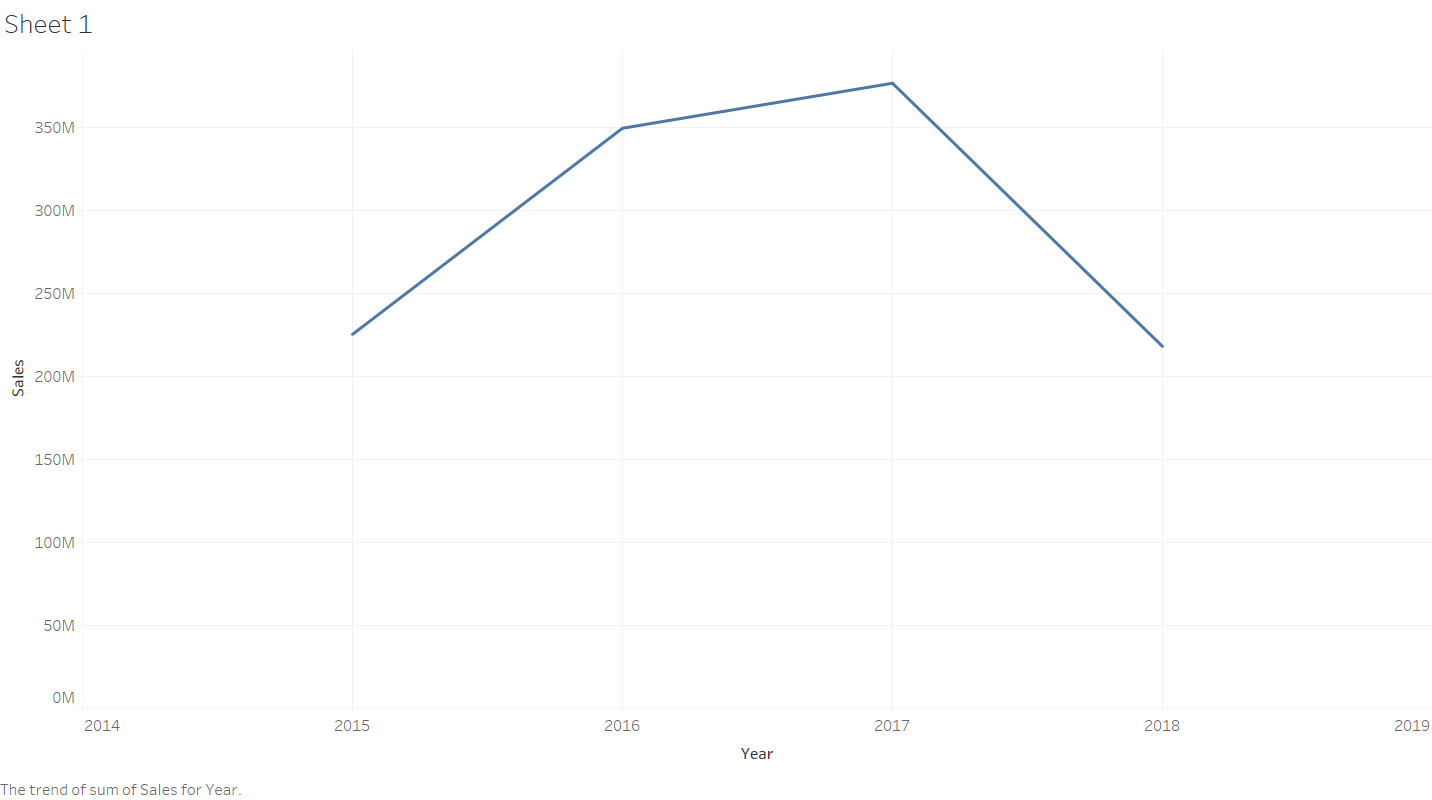

In [ ]:
from IPython.display import Image
Image(filename="/content/gdrive/MyDrive/final hackathon datasets/Sheet 1.png")
#the sum of sales of mesicine is maximum for the year 2017

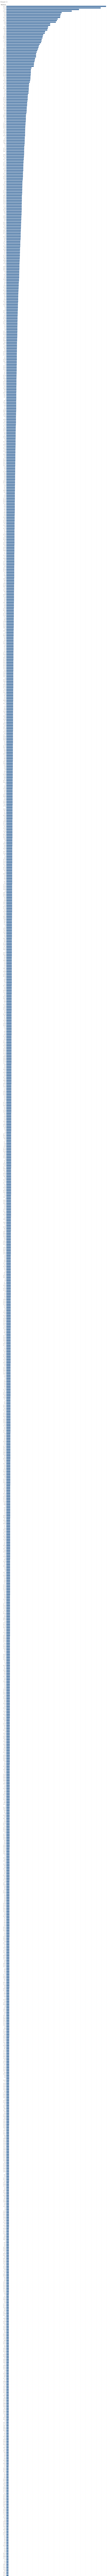

In [3]:
from IPython.display import Image
Image(filename="/content/gdrive/MyDrive/final hackathon datasets/Sheet 3.png")
#medicine category with maximum sum of sales is 1077

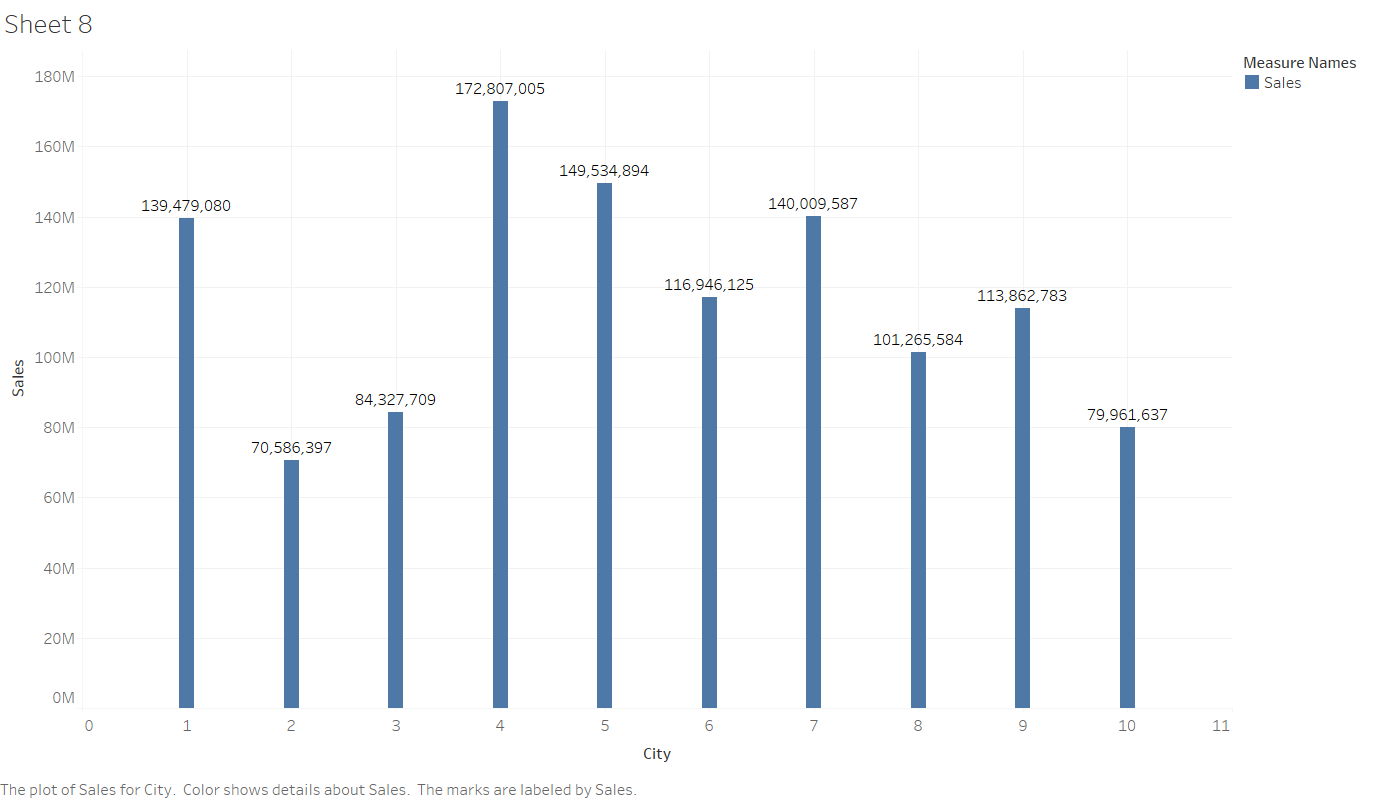

In [ ]:
from IPython.display import Image
Image(filename="/content/gdrive/MyDrive/final hackathon datasets/Sheet 8.png")
#Maximum sum of sales is for the city 4

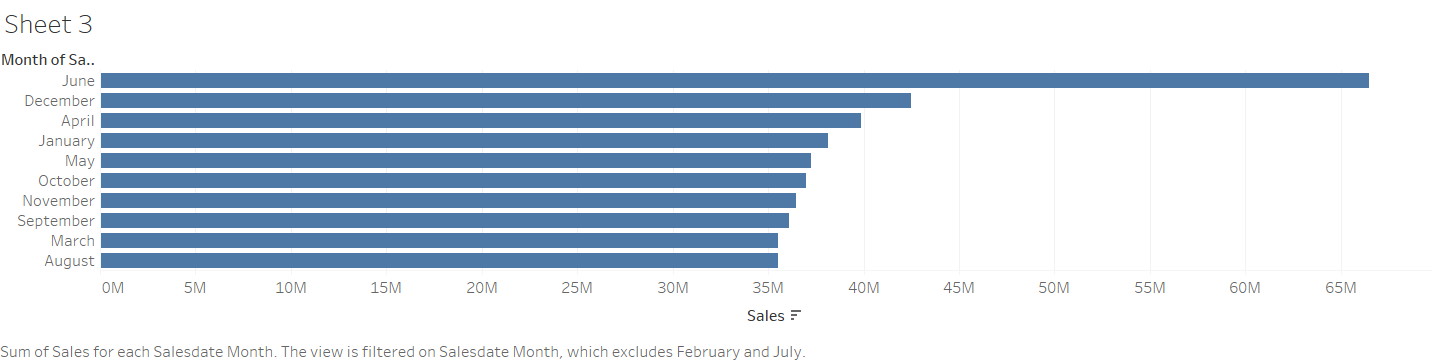

In [3]:
from IPython.display import Image
Image(filename="/content/gdrive/MyDrive/final hackathon datasets/Sheet 15.png")
#The maximum sum of sales for one year data is for the month of june

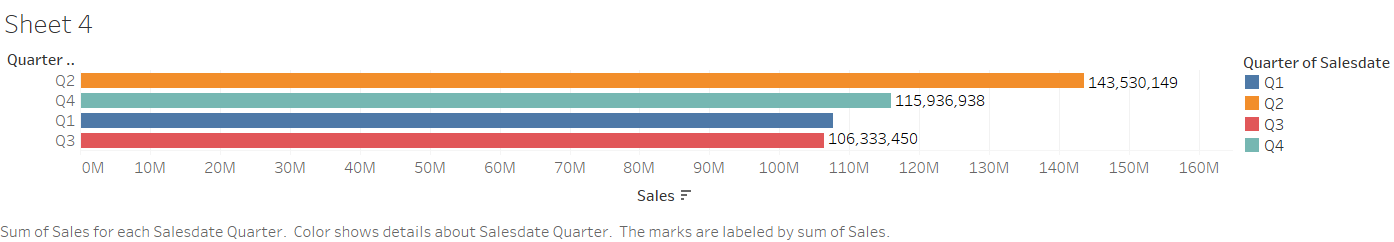

In [4]:
from IPython.display import Image
Image(filename="/content/gdrive/MyDrive/final hackathon datasets/Sheet 16.png")
#Maximum sum of sales is in the second quarter for year 2017,2018

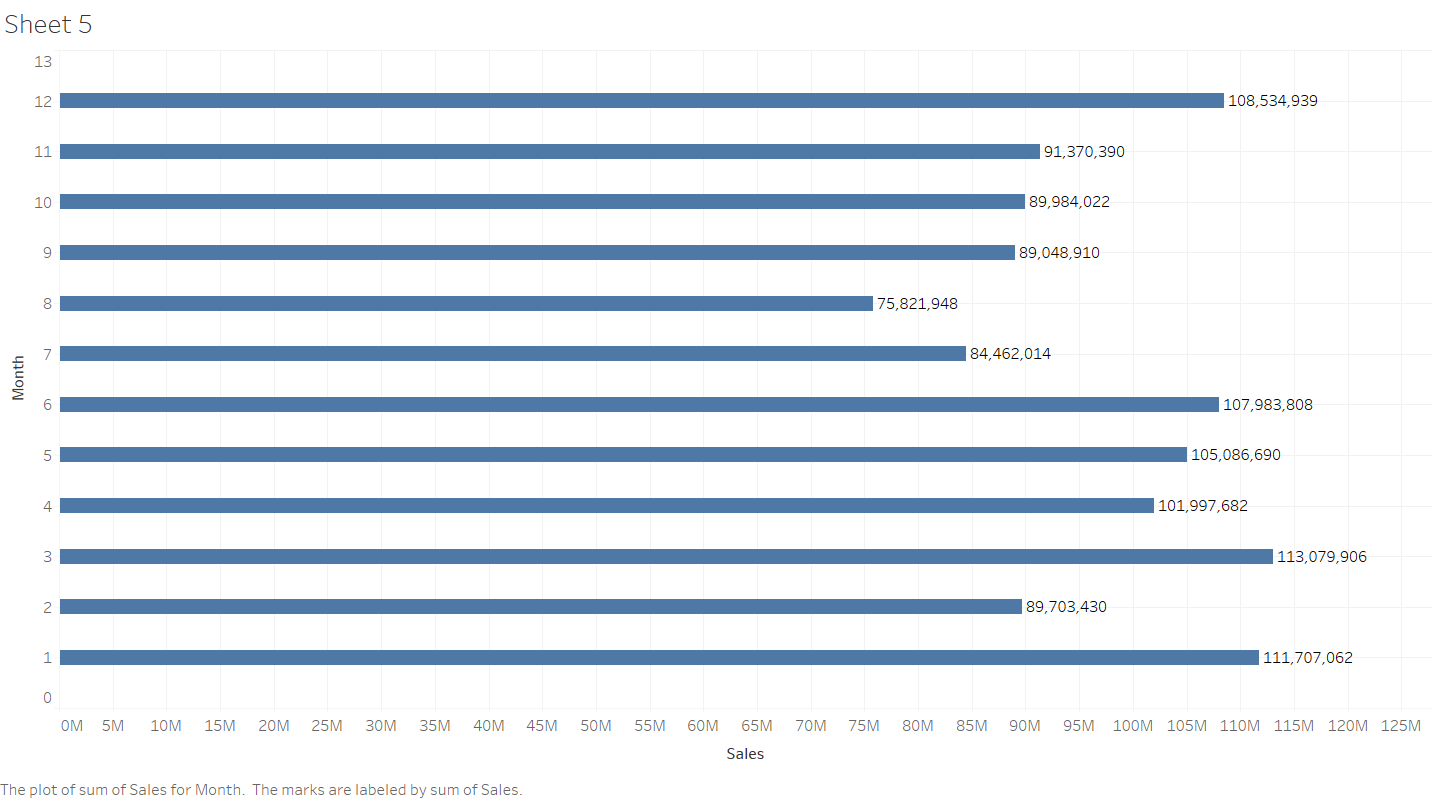

In [7]:
from IPython.display import Image
Image(filename="/content/gdrive/MyDrive/final hackathon datasets/Sheet 5.png")

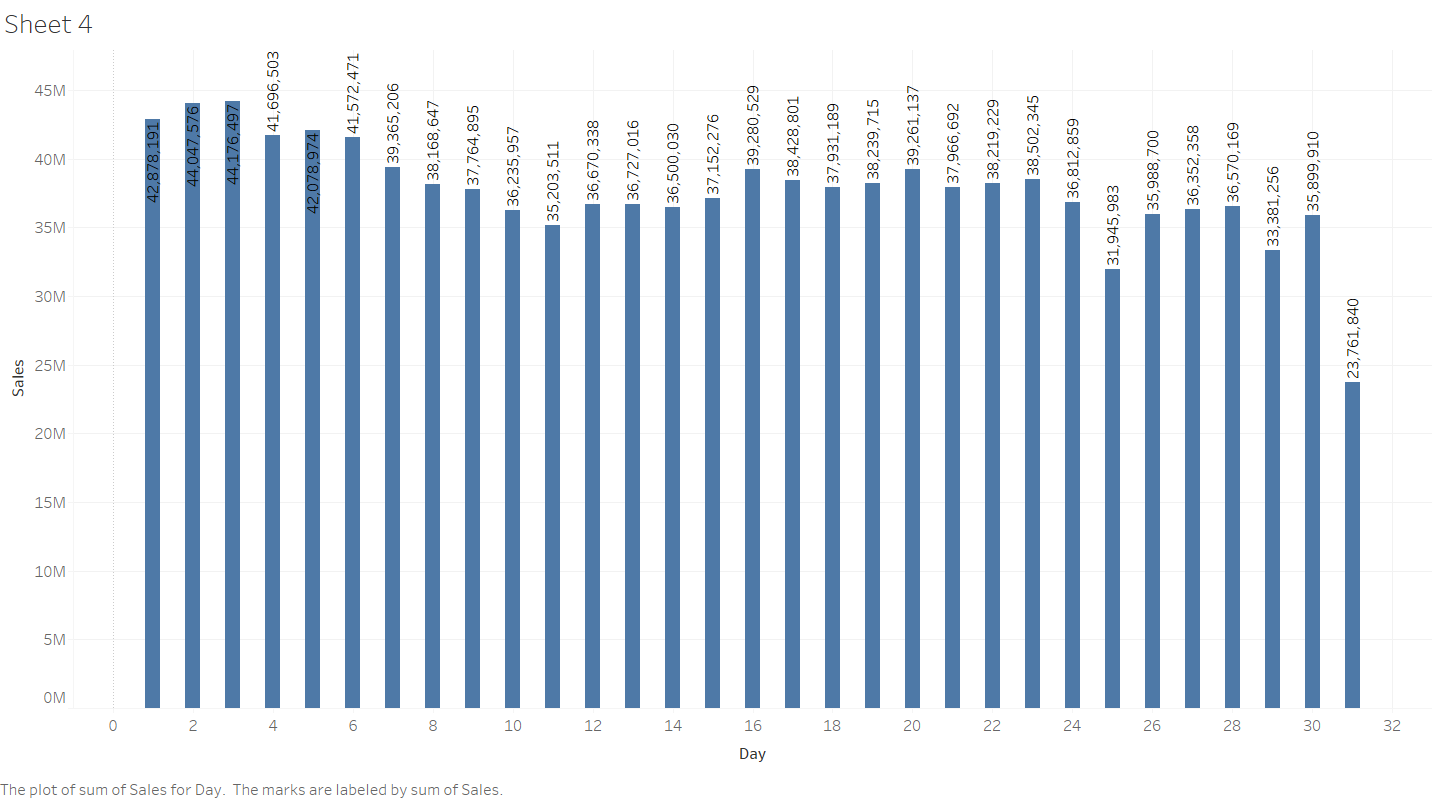

In [8]:
from IPython.display import Image
Image(filename="/content/gdrive/MyDrive/final hackathon datasets/Sheet 4.png")

In [ ]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if col_type == 'datetime64[ns]':
              print ("")
            elif str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [ ]:
train_data1=reduce_mem_usage(train_data1)

Memory usage of dataframe is 421.83 MB
Memory usage after optimization is: 123.05 MB
Decreased by 70.8%


In [ ]:
test_data1=reduce_mem_usage(test_data1)

Memory usage of dataframe is 35.41 MB
Memory usage after optimization is: 10.33 MB
Decreased by 70.8%


In [ ]:
train_data1 = train_data1.drop(columns=train_data1.columns[0])
train_data1

,salesdate,city,medicine,sales,discounted
0,2017-06-02,1,25.640625,16.0,0
1,2017-06-02,1,23.156250,12.0,0
2,2017-06-02,1,77.000000,80.0,0
3,2017-06-02,1,132.875000,40.0,0
4,2017-06-02,1,25.093750,20.0,0
...,...,...,...,...,...
9215081,2018-06-30,10,11.531250,8.0,1
9215082,2018-06-30,10,47.375000,16.0,0
9215083,2018-06-30,10,66.312500,8.0,0
9215084,2018-06-30,10,34.250000,4.0,0


In [ ]:

test_data1

,Unnamed: 0,salesdate,id,city,medicine,discounted
0,0,2018-07-01,1,1,25.640625,0.0
1,1,2018-07-01,2,1,23.156250,0.0
2,2,2018-07-01,3,1,77.000000,1.0
3,3,2018-07-01,4,1,132.875000,0.0
4,4,2018-07-01,5,1,25.093750,0.0
...,...,...,...,...,...,...
773530,773530,2018-07-31,773531,10,47.375000,0.0
773531,773531,2018-07-31,773532,10,66.312500,0.0
773532,773532,2018-07-31,773533,10,34.250000,0.0
773533,773533,2018-07-31,773534,10,54.406250,0.0


In [ ]:
test_data1=test_data1.drop(columns=test_data1.columns[0])
test_data1

,salesdate,id,city,medicine,discounted
0,2018-07-01,1,1,25.640625,0.0
1,2018-07-01,2,1,23.156250,0.0
2,2018-07-01,3,1,77.000000,1.0
3,2018-07-01,4,1,132.875000,0.0
4,2018-07-01,5,1,25.093750,0.0
...,...,...,...,...,...
773530,2018-07-31,773531,10,47.375000,0.0
773531,2018-07-31,773532,10,66.312500,0.0
773532,2018-07-31,773533,10,34.250000,0.0
773533,2018-07-31,773534,10,54.406250,0.0


In [ ]:
test_data1=test_data1.drop(columns=test_data1.columns[1])
test_data1

,salesdate,city,medicine,discounted
0,2018-07-01,1,25.640625,0.0
1,2018-07-01,1,23.156250,0.0
2,2018-07-01,1,77.000000,1.0
3,2018-07-01,1,132.875000,0.0
4,2018-07-01,1,25.093750,0.0
...,...,...,...,...
773530,2018-07-31,10,47.375000,0.0
773531,2018-07-31,10,66.312500,0.0
773532,2018-07-31,10,34.250000,0.0
773533,2018-07-31,10,54.406250,0.0


In [ ]:
train_data1["month"]=pd.DatetimeIndex(train_data1['salesdate']).month
train_data1["year"]=pd.DatetimeIndex(train_data1['salesdate']).year
train_data1["day"]=pd.DatetimeIndex(train_data1['salesdate']).dayofweek
train_data1
train_data1.drop("salesdate",axis=1,inplace=True)

In [ ]:
train_data1.head()

,city,medicine,sales,discounted,month,year,day
0,1,25.640625,16.0,0,6,2017,4
1,1,23.156250,12.0,0,6,2017,4
2,1,77.000000,80.0,0,6,2017,4
3,1,132.875000,40.0,0,6,2017,4
4,1,25.093750,20.0,0,6,2017,4


In [ ]:
test_data1["month"]=pd.DatetimeIndex(test_data1['salesdate']).month
test_data1["year"]=pd.DatetimeIndex(test_data1['salesdate']).year
test_data1["day"]=pd.DatetimeIndex(test_data1['salesdate']).dayofweek
test_data1
test_data1.drop("salesdate",axis=1,inplace=True)

In [ ]:

test_data1.head()

,city,medicine,discounted,month,year,day
0,1,25.640625,0.0,7,2018,6
1,1,23.156250,0.0,7,2018,6
2,1,77.000000,1.0,7,2018,6
3,1,132.875000,0.0,7,2018,6
4,1,25.093750,0.0,7,2018,6


In [ ]:
train_data1.dtypes

city             int8
medicine      float16
sales         float32
discounted       int8
month           int64
year            int64
day             int64
dtype: object

In [ ]:
train_data1['city'] = train_data1['city'].astype('category')
train_data1['discounted'] = train_data1['discounted'].astype('category')
train_data1["month"]=train_data1["month"].astype("category")
train_data1["year"]=train_data1["year"].astype("category")
train_data1["day"]=train_data1["day"].astype("category")
train_data1["sales"]=train_data1["sales"].astype("float64")



In [ ]:
test_data1['city'] = test_data1['city'].astype('category')
test_data1['discounted'] = test_data1['discounted'].astype('category')
test_data1["month"]=test_data1["month"].astype("category")
test_data1["year"]=test_data1["year"].astype("category")

test_data1["day"]=test_data1["day"].astype("category")

In [ ]:
train_data1.dtypes

city          category
medicine       float16
sales          float64
discounted    category
month         category
year          category
day           category
dtype: object

In [ ]:
#Train Test Split
Y = train_data1.sales
#print(Y.head())
X = train_data1.drop('sales', axis=1)

#X.head()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.30, random_state = 234)

In [ ]:
# test_data1
del train_data1

In [ ]:

import gc
gc.collect()

54

In [ ]:
X_train.shape

(6450560, 6)

In [ ]:
X_train.head()

,city,medicine,discounted,month,year,day
2102863,2,32.562500,0,9,2017,3
6650010,3,37.250000,0,3,2018,6
6494830,9,7.726562,0,3,2018,6
456950,5,18.093750,0,6,2017,4
3660563,9,37.375000,1,11,2017,0


In [ ]:
X_test.tail()

,city,medicine,discounted,month,year,day
7540446,4,55.156250,0,4,2018,0
603541,4,557.500000,0,6,2017,4
4366,3,29.468750,0,6,2017,4
7435084,1,72.500000,0,4,2018,3
3552867,2,28.484375,1,11,2017,3


In [ ]:
#print(train_data1.shape)
#print(test_data1.shape)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(6450560, 6)
(2764526, 6)
(6450560,)
(2764526,)


In [ ]:

X_train.dtypes

city          category
medicine       float16
discounted    category
month         category
year          category
day           category
dtype: object

In [ ]:
categ_cols = ['year', 'month', 'day', 'city', 'discounted']
num_cols = ['medicine']

# DataFrameMapper, a class for mapping pandas data frame columns to different sklearn transformations
mapper = DataFrameMapper(
  [([continuous_col], StandardScaler()) for continuous_col in num_cols] +
  [([categorical_col], OneHotEncoder(handle_unknown="ignore")) for categorical_col in categ_cols]
, df_out=True)

print(mapper)

DataFrameMapper(df_out=True,
                features=[(['medicine'], StandardScaler()),
                          (['year'], OneHotEncoder(handle_unknown='ignore')),
                          (['month'], OneHotEncoder(handle_unknown='ignore')),
                          (['day'], OneHotEncoder(handle_unknown='ignore')),
                          (['city'], OneHotEncoder(handle_unknown='ignore')),
                          (['discounted'],
                           OneHotEncoder(handle_unknown='ignore'))])


In [ ]:
# Fitting on train data
mapper.fit(X_train)

# Transforming on train, val and test data
X_train = mapper.transform(X_train)
X_test = mapper.transform(X_test)
test_data1 = mapper.transform(test_data1)

In [ ]:
test_data1['medicine'].fillna(Y_train.mean(), inplace = True)

In [ ]:
gc.collect()

100

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [2,5,7,10,12,15,20,24,27],
    'min_samples_leaf': [1, 5, 10],
    'max_leaf_nodes' : [5,10,12,20],
    #'ccp_alpha' : [0.1,0.01,0.001,0.0001],
    'class_weight' : ['balanced','None']
}

In [ ]:
#regr1 = DecisionTreeRegressor()
regr = GridSearchCV(estimator= DecisionTreeClassifier(), 
                     param_grid= param_grid,
                     cv = 3)


In [ ]:
regr1.fit(X_train, Y_train)

DecisionTreeRegressor()

In [ ]:
#del X_train
#del Y_train

In [ ]:
Y_train_pred = regr1.predict(X_train)
Y_test_pred = regr1.predict(X_test)

In [ ]:
from sklearn.metrics import mean_squared_error
rmseTrain = mean_squared_error(Y_train, Y_train_pred, squared=False)
rmseTrain

59.43180703187591

In [ ]:
np.sqrt(mean_squared_error(Y_train, Y_train_pred))

59.43180703187591

In [ ]:
rmseTest = mean_squared_error(Y_test, Y_test_pred,squared=False)
rmseTest

73.45186275352627

In [ ]:
yProdPred = regr1.predict(test_data1)

In [ ]:
yProdPred

array([16. , 24. , 56. , ..., 32.5, 12. , 29. ])

In [ ]:
#Read the sample file
SampleFile = pd.read_csv('/content/sample_submission-1638436274177.csv')
print(SampleFile.shape)
SampleFile.head(5)

(773535, 2)


,id,sales
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [ ]:
PredictedY = pd.DataFrame(yProdPred)
dfList = [SampleFile, PredictedY]

In [ ]:
PredictedY.head()

,0
0,16.000000
1,24.000000
2,56.000000
3,45.142857
4,16.000000


In [ ]:
SampleFile = pd.concat(dfList, axis=1)


In [ ]:
print(SampleFile.shape)
SampleFile.head(2)

(773535, 3)


,id,sales,0
0,1,0,16.0
1,2,0,24.0


In [ ]:
SampleFile.drop(['sales'], axis=1, inplace=True)

In [ ]:

SampleFile.rename(columns={0:'sales'}, inplace=True)

In [ ]:

print(SampleFile.shape)
SampleFile.sample(10)

(773535, 2)


,id,sales
187594,187595,508.975993
164910,164911,66.285714
650473,650474,23.333333
233639,233640,12.666667
188461,188462,42.000000
522986,522987,44.000000
311619,311620,21.473684
282481,282482,13.090909
544764,544765,74.666667
73471,73472,60.666667


In [ ]:
SampleFile.to_csv("AYUSH_MISHRA_B95_PhD_DT4.csv",index=False)